### Pose Extraction

This notebook extracts poses from the EmotiW training/validation video clips using the OpenPose library.

Note that OpenPose is used directly as a CLI tool so one of the first steps is to actually build the openpose binary (this takes a long time - 20 min or so)

In [0]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

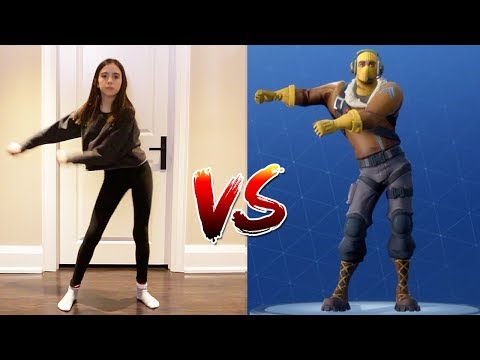

In [0]:
YOUTUBE_ID = 'RXABo9hm8B8'


YouTubeVideo(YOUTUBE_ID)

In [0]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the first 5 seconds
!ffmpeg -y -loglevel info -i youtube.mp4 -t 5 video.mp4
# detect poses on the these 5 seconds
!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

[youtube] RXABo9hm8B8: Downloading webpage
[download] Destination: youtube.mp4
[download] 100% of 116.25MiB in 00:03
ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-li

In [0]:
!ls openpose/examples/openpose

CMakeLists.txt	openpose.cpp


In [0]:
import sys
sys.path.append('openpose/python');

In [0]:
!ls openpose/build/examples/openpose/

CMakeFiles  cmake_install.cmake  Makefile  openpose.bin


In [0]:
from openpose import pyopenpose as op

ImportError: ignored

In [0]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [0]:
!cat openpose/output/video_000000000000_keypoints.json


{"version":1.3,"people":[{"person_id":[-1],"pose_keypoints_2d":[553.917,91.7844,0.864328,553.724,206.598,0.844484,453.672,200.54,0.789382,388.893,347.839,0.852618,444.889,453.784,0.837943,656.8,221.243,0.746947,739.271,338.908,0.916354,692.228,453.805,0.865439,509.736,500.768,0.676044,447.905,483.171,0.628374,306.616,633.31,0.740294,247.651,859.934,0.734681,577.317,509.754,0.660057,577.379,742.208,0.748003,577.515,951.259,0.782331,533.344,77.0215,0.852847,577.328,79.7889,0.93374,506.693,85.9367,0.950469,600.926,94.7319,0.899188,592.09,1001.11,0.764104,615.58,995.268,0.779178,574.301,965.846,0.622596,194.792,901.107,0.378226,188.891,883.535,0.387106,250.758,880.549,0.531769],"face_keypoints_2d":[],"hand_left_keypoints_2d":[],"hand_right_keypoints_2d":[],"pose_keypoints_3d":[],"face_keypoints_3d":[],"hand_left_keypoints_3d":[],"hand_right_keypoints_3d":[]},{"person_id":[-1],"pose_keypoints_2d":[1445.71,150.678,0.176657,1413.26,227.099,0.815578,1360.32,241.884,0.767681,1336.72,247.761,0.8

In [0]:
!./openpose/build/examples/openpose/openpose.bin

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...

Error:
No camera found.

Coming from:
- /content/openpose/src/openpose/producer/producer.cpp:createProducer():464
- /content/openpose/src/openpose/producer/producer.cpp:createProducer():475
- /content/openpose/include/openpose/wrapper/wrapperAuxiliary.hpp:configureThreadManager():1222
- /content/openpose/include/openpose/wrapper/wrapper.hpp:exec():424


In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/emotiw/train_frames.tar.gz' .

In [0]:
!tar -xzf train_frames.tar.gz

In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/emotiw/val_frames.tar.gz' .
!tar -xzf val_frames.tar.gz

In [0]:
!mkdir test

In [0]:
!ls train_frames/1 | head

frame_101_10.mp4_0.jpg
frame_101_10.mp4_10.jpg
frame_101_10.mp4_11.jpg
frame_101_10.mp4_12.jpg
frame_101_10.mp4_13.jpg
frame_101_10.mp4_14.jpg
frame_101_10.mp4_1.jpg
frame_101_10.mp4_2.jpg
frame_101_10.mp4_3.jpg
frame_101_10.mp4_4.jpg


In [0]:
!cp train_frames/1/frame_101_10.mp4_0.jpg test
!cp train_frames/1/frame_101_10.mp4_10.jpg test
!cp train_frames/1/frame_101_10.mp4_11.jpg test

In [0]:
!ls test

frame_101_10.mp4_0.jpg	frame_101_10.mp4_10.jpg  frame_101_10.mp4_11.jpg


In [0]:
!nvidia-smi

Sat May 23 20:29:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!mkdir /content/train_frames_keypoints
!mkdir /content/train_frames_keypoints/1
!mkdir /content/train_frames_keypoints/2
!mkdir /content/train_frames_keypoints/3

!mkdir /content/val_frames_keypoints
!mkdir /content/val_frames_keypoints/1
!mkdir /content/val_frames_keypoints/2
!mkdir /content/val_frames_keypoints/3

In [0]:
!ls /content/train_frames/1 | head

frame_101_10.mp4_0.jpg
frame_101_10.mp4_10.jpg
frame_101_10.mp4_11.jpg
frame_101_10.mp4_12.jpg
frame_101_10.mp4_13.jpg
frame_101_10.mp4_14.jpg
frame_101_10.mp4_1.jpg
frame_101_10.mp4_2.jpg
frame_101_10.mp4_3.jpg
frame_101_10.mp4_4.jpg


In [0]:
import subprocess
import os

os.chdir("/content/openpose")

p = subprocess.run(["build/examples/openpose/openpose.bin", "--image_dir", "/content/train_frames/1", "--write_json", "/content/train_frames_keypoints/1", "--display", "0", "--render_pose", "0"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding='utf-8')
print(p.stdout)
print(p.stderr)


Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 2485.453765 seconds.




In [0]:

p = subprocess.run(["build/examples/openpose/openpose.bin", "--image_dir", "/content/train_frames/2", "--write_json", "/content/train_frames_keypoints/2", "--display", "0", "--render_pose", "0"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding='utf-8')
print(p.stdout)
print(p.stderr)

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 2870.578980 seconds.




In [0]:

p = subprocess.run(["build/examples/openpose/openpose.bin", "--image_dir", "/content/train_frames/3", "--write_json", "/content/train_frames_keypoints/3", "--display", "0", "--render_pose", "0"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding='utf-8')
print(p.stdout)
print(p.stderr)

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 2864.065358 seconds.




In [0]:

p = subprocess.run(["build/examples/openpose/openpose.bin", "--image_dir", "/content/val_frames/1", "--write_json", "/content/val_frames_keypoints/1", "--display", "0", "--render_pose", "0"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding='utf-8')
print(p.stdout)
print(p.stderr)

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 890.596354 seconds.




In [0]:

p = subprocess.run(["build/examples/openpose/openpose.bin", "--image_dir", "/content/val_frames/2", "--write_json", "/content/val_frames_keypoints/2", "--display", "0", "--render_pose", "0"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding='utf-8')
print(p.stdout)
print(p.stderr)

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 817.224047 seconds.




In [0]:

p = subprocess.run(["build/examples/openpose/openpose.bin", "--image_dir", "/content/val_frames/3", "--write_json", "/content/val_frames_keypoints/3", "--display", "0", "--render_pose", "0"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding='utf-8')
print(p.stdout)
print(p.stderr)

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 559.737443 seconds.




In [0]:
!ls /content/train_frames_keypoints/3 | head

frame_101_12.mp4_0_keypoints.json
frame_101_12.mp4_10_keypoints.json
frame_101_12.mp4_11_keypoints.json
frame_101_12.mp4_12_keypoints.json
frame_101_12.mp4_13_keypoints.json
frame_101_12.mp4_14_keypoints.json
frame_101_12.mp4_1_keypoints.json
frame_101_12.mp4_2_keypoints.json
frame_101_12.mp4_3_keypoints.json
frame_101_12.mp4_4_keypoints.json


In [0]:
!pwd

/content/openpose


In [0]:
!tar -zcvf /content/train_frames_keypoints.tar.gz /content/train_frames_keypoints


Streaming output truncated to the last 5000 lines.
/content/train_frames_keypoints/3/frame_322_3.mp4_5_keypoints.json
/content/train_frames_keypoints/3/frame_220_12.mp4_1_keypoints.json
/content/train_frames_keypoints/3/frame_341_2.mp4_14_keypoints.json
/content/train_frames_keypoints/3/frame_303_35.mp4_1_keypoints.json
/content/train_frames_keypoints/3/frame_108_10.mp4_8_keypoints.json
/content/train_frames_keypoints/3/frame_328_19.mp4_0_keypoints.json
/content/train_frames_keypoints/3/frame_158_27.mp4_7_keypoints.json
/content/train_frames_keypoints/3/frame_170_7.mp4_14_keypoints.json
/content/train_frames_keypoints/3/frame_316_3.mp4_3_keypoints.json
/content/train_frames_keypoints/3/frame_319_12.mp4_7_keypoints.json
/content/train_frames_keypoints/3/frame_93_12.mp4_6_keypoints.json
/content/train_frames_keypoints/3/frame_169_14.mp4_8_keypoints.json
/content/train_frames_keypoints/3/frame_106_4.mp4_11_keypoints.json
/content/train_frames_keypoints/3/frame_3_18.mp4_4_keypoints.json
/c

In [0]:
!tar -zcvf /content/val_frames_keypoints.tar.gz /content/val_frames_keypoints


Streaming output truncated to the last 5000 lines.
/content/val_frames_keypoints/2/frame_298_44.mp4_0_keypoints.json
/content/val_frames_keypoints/2/frame_294_22.mp4_5_keypoints.json
/content/val_frames_keypoints/2/frame_181_2.mp4_13_keypoints.json
/content/val_frames_keypoints/2/frame_294_37.mp4_3_keypoints.json
/content/val_frames_keypoints/2/frame_325_54.mp4_4_keypoints.json
/content/val_frames_keypoints/2/frame_298_49.mp4_7_keypoints.json
/content/val_frames_keypoints/2/frame_268_7.mp4_12_keypoints.json
/content/val_frames_keypoints/2/frame_325_48.mp4_13_keypoints.json
/content/val_frames_keypoints/2/frame_325_48.mp4_5_keypoints.json
/content/val_frames_keypoints/2/frame_333_2.mp4_0_keypoints.json
/content/val_frames_keypoints/2/frame_55_17.mp4_11_keypoints.json
/content/val_frames_keypoints/2/frame_154_10.mp4_14_keypoints.json
/content/val_frames_keypoints/2/frame_53_44.mp4_2_keypoints.json
/content/val_frames_keypoints/2/frame_154_2.mp4_4_keypoints.json
/content/val_frames_keypoi

In [0]:
!cp /content/val_frames_keypoints.tar.gz /content/drive/'My Drive'/cs231n-project/datasets/val_frames_keypoints.tar.gz
!cp /content/train_frames_keypoints.tar.gz /content/drive/'My Drive'/cs231n-project/datasets/train_frames_keypoints.tar.gz

In [0]:
!ls '/content/drive/My Drive/cs231n-project/datasets/'

emotiw	flickr.tar.gz		       val_frames_keypoints.tar.gz
flickr	train_frames_keypoints.tar.gz
